In [1]:
import os
import math
import random
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [2]:
TRAIN_PATH = "data/train_FD002.txt"
TEST_PATH = "data/test_FD002.txt"
RUL_PATH = "data/RUL_FD002.txt"
MODEL_PATH = "best_model_fd002_hyper.pth"
SCALER_PATH = "scaler_fd002_hyper.pkl"


SEQ_LEN = 80 
STEP = 1
BATCH_SIZE = 128
LR = 5e-4
EPOCHS = 100
PATIENCE = 15
RUL_CAP = 130 # NASA common cap for RUL targets
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42

# reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

In [3]:
def read_cmapss(path):
# load and trim trailing empty columns
    df = pd.read_csv(path, sep=" ", header=None).dropna(axis=1, how="all")
    return df


# ---------------------- LOAD DATA ----------------------
train_raw = read_cmapss(TRAIN_PATH)
test_raw = read_cmapss(TEST_PATH)
rul_raw = read_cmapss(RUL_PATH)


# standard CMAPSS columns (FD files have 26 columns typically after dropna)
cols = ["unit", "cycle"] + [f"op_setting_{i}" for i in range(1,4)] + [f"sensor_{i}" for i in range(1,22)]
train_raw = train_raw.iloc[:, :len(cols)]
train_raw.columns = cols


test_raw = test_raw.iloc[:, :len(cols)]
test_raw.columns = cols

In [4]:
# I've chosen the commonly used informative sensors for FD004 (keeps noise low)
selected_features = [
"op_setting_1","op_setting_2","op_setting_3",
"sensor_2","sensor_3","sensor_4","sensor_7","sensor_8",
"sensor_9","sensor_11","sensor_12","sensor_13","sensor_14","sensor_15"
]


# Keep only cols of interest + unit,cycle
train_df = train_raw[["unit","cycle"] + selected_features].copy()
# We'll compute RUL next


# ---------------------- COMPUTE RUL (TRAIN) WITH CAPPING ----------------------
# RUL per row: remaining cycles until failure for engines in train set
train_max = train_raw.groupby("unit")["cycle"].max().to_dict()
train_df["RUL"] = train_df.apply(lambda r: train_max[r["unit"]] - r["cycle"], axis=1)
train_df["RUL"] = train_df["RUL"].clip(upper=RUL_CAP)


# ---------------------- TEST RULs (from provided RUL file) ----------------------
rul_vals = rul_raw.iloc[:,0].values.flatten()
# map engine->true remaining cycles (for test units in order)
test_units = sorted(test_raw["unit"].unique())
test_rul_map = {u: int(r) for u, r in zip(test_units, rul_vals)}


# Prepare test dataframe with features
test_df = test_raw[["unit","cycle"] + selected_features].copy()

In [5]:
scaler = StandardScaler()
scaler.fit(train_df[selected_features].values)
train_df[selected_features] = scaler.transform(train_df[selected_features].values)
# Apply same scaler on test
test_df[selected_features] = scaler.transform(test_df[selected_features].values)


# Save scaler for later inference
with open(SCALER_PATH, "wb") as f:
    pickle.dump(scaler, f)
print("Saved scaler to", SCALER_PATH)

Saved scaler to scaler_fd002_hyper.pkl


In [6]:
def create_sequences_by_units(df, units_list, seq_len=SEQ_LEN, step=STEP):
    X, y = [], []
    for uid in units_list:
        unit_df = df[df["unit"] == uid].reset_index(drop=True)
        feats = unit_df[selected_features].values
        labels = unit_df["RUL"].values
        L = len(unit_df)
        if L < seq_len:
    # pad at front with first row (rare), ensures consistent length
            pad_len = seq_len - L
            pad = np.repeat(feats[[0]], pad_len, axis=0)
            feats_pad = np.vstack([pad, feats])
            # label corresponds to last time (end)
            X.append(feats_pad.astype(np.float32))
            y.append(labels[-1])
        else:
            for start in range(0, L - seq_len + 1, step):
                end = start + seq_len
                X.append(feats[start:end].astype(np.float32))
                y.append(labels[end-1])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

In [7]:
units = sorted(train_df["unit"].unique())
n_units = len(units)
train_units = units[: int(n_units * 0.8)]
val_units = units[int(n_units * 0.8):]


X_train, y_train = create_sequences_by_units(train_df, train_units, SEQ_LEN, STEP)
X_val, y_val = create_sequences_by_units(train_df, val_units, SEQ_LEN, STEP)


print("X_train", X_train.shape, "y_train", y_train.shape)
print("X_val", X_val.shape, "y_val", y_val.shape)

X_train (26671, 80, 14) y_train (26671,)
X_val (6548, 80, 14) y_val (6548,)


In [8]:
# Build test last-window per engine
def build_test_last_windows(test_df, rul_map, seq_len=SEQ_LEN):
    X_test = []
    y_test = []
    units_sorted = sorted(test_df["unit"].unique())
    for uid in units_sorted:
        unit_df = test_df[test_df["unit"] == uid].reset_index(drop=True)
        feats = unit_df[selected_features].values
        if len(unit_df) < seq_len:
            pad_len = seq_len - len(unit_df)
            pad = np.repeat(feats[[0]], pad_len, axis=0)
            window = np.vstack([pad, feats])
        else:
            window = feats[-seq_len:]
        X_test.append(window.astype(np.float32))
        y_test.append(min(rul_map[uid], RUL_CAP))
    return np.array(X_test, dtype=np.float32), np.array(y_test, dtype=np.float32), units_sorted


X_test, y_test, test_units = build_test_last_windows(test_df, test_rul_map, SEQ_LEN)
print("X_test", X_test.shape, "y_test", y_test.shape)

X_test (259, 80, 14) y_test (259,)


In [9]:
class SeqDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_loader = DataLoader(SeqDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(SeqDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(SeqDataset(X_test, y_test), batch_size=64, shuffle=False)

In [10]:
class Attention(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.attn = nn.Sequential(
            nn.Linear(dim, dim),
            nn.Tanh(),
            nn.Linear(dim, 1)
            )
    def forward(self, x):
        # x: (batch, seq, hidden)
        w = self.attn(x) # (batch, seq, 1)
        w = torch.softmax(w, dim=1) # softmax over seq
        out = (x * w).sum(dim=1) # weighted sum -> (batch, hidden)
        return out


class SmallModel(nn.Module):
    def __init__(self, input_dim, cnn_filters=64, lstm_hidden=128, lstm_layers=2, dropout=0.3):
        super().__init__()
        self.cnn = nn.Conv1d(input_dim, cnn_filters, kernel_size=3, padding=1)
        self.lstm = nn.LSTM(
            input_size=cnn_filters,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if lstm_layers>1 else 0.0
            )
        self.attn = Attention(2 * lstm_hidden)
        self.fc = nn.Sequential(
            nn.Linear(2 * lstm_hidden, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 1)
            )
    def forward(self, x):
    # x: (B, T, F)
        x = x.permute(0,2,1) # (B, F, T) for Conv1d
        x = self.cnn(x)
        x = x.permute(0,2,1) # (B, T, C)
        x, _ = self.lstm(x)
        x = self.attn(x)
        return self.fc(x)

In [11]:
# Instantiate model
model = SmallModel(input_dim=len(selected_features)).to(DEVICE)
print(model)

SmallModel(
  (cnn): Conv1d(14, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (lstm): LSTM(64, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (attn): Attention(
    (attn): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): Tanh()
      (2): Linear(in_features=256, out_features=1, bias=True)
    )
  )
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [12]:

# ---------------------- TRAINING ----------------------
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=4)

best_val = float('inf')
wait = 0
train_hist = { 'train_loss':[], 'val_loss':[], 'train_mae':[], 'val_mae':[] }

for epoch in range(1, EPOCHS+1):
    model.train()
    t_loss = 0.0
    t_mae  = 0.0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        pred = model(Xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        t_loss += loss.item() * Xb.size(0)
        t_mae  += torch.nn.functional.l1_loss(pred, yb, reduction='sum').item()
    t_loss /= len(train_loader.dataset)
    t_mae  /= len(train_loader.dataset)

    # validation
    model.eval()
    v_loss = 0.0
    v_mae  = 0.0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)
            pred = model(Xb)
            v_loss += criterion(pred, yb).item() * Xb.size(0)
            v_mae  += torch.nn.functional.l1_loss(pred, yb, reduction='sum').item()
    v_loss /= len(val_loader.dataset)
    v_mae  /= len(val_loader.dataset)

    scheduler.step(v_loss)

    train_hist['train_loss'].append(t_loss)
    train_hist['val_loss'].append(v_loss)
    train_hist['train_mae'].append(t_mae)
    train_hist['val_mae'].append(v_mae)

    print(f"Epoch {epoch:03d} | Train Loss {t_loss:.4f} | Val Loss {v_loss:.4f} | Train MAE {t_mae:.4f} | Val MAE {v_mae:.4f}")

    if v_loss < best_val - 1e-6:
        best_val = v_loss
        wait = 0
        torch.save(model.state_dict(), MODEL_PATH)
        print("  -> New best model saved")
    else:
        wait += 1
        if wait >= PATIENCE:
            print(f"Early stopping at epoch {epoch}. Best epoch saved.")
            break

# load best model
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()



Epoch 001 | Train Loss 41.9836 | Val Loss 35.2727 | Train MAE 42.4811 | Val MAE 35.7702
  -> New best model saved
Epoch 002 | Train Loss 35.0988 | Val Loss 35.2450 | Train MAE 35.5962 | Val MAE 35.7430
  -> New best model saved
Epoch 003 | Train Loss 35.0200 | Val Loss 29.7356 | Train MAE 35.5175 | Val MAE 30.2321
  -> New best model saved
Epoch 004 | Train Loss 23.0565 | Val Loss 17.5343 | Train MAE 23.5509 | Val MAE 18.0268
  -> New best model saved
Epoch 005 | Train Loss 16.2313 | Val Loss 13.6683 | Train MAE 16.7228 | Val MAE 14.1589
  -> New best model saved
Epoch 006 | Train Loss 13.8313 | Val Loss 12.4534 | Train MAE 14.3207 | Val MAE 12.9441
  -> New best model saved
Epoch 007 | Train Loss 12.3723 | Val Loss 11.3941 | Train MAE 12.8603 | Val MAE 11.8799
  -> New best model saved
Epoch 008 | Train Loss 11.1491 | Val Loss 12.3398 | Train MAE 11.6351 | Val MAE 12.8258
Epoch 009 | Train Loss 10.5523 | Val Loss 10.8835 | Train MAE 11.0378 | Val MAE 11.3686
  -> New best model saved


SmallModel(
  (cnn): Conv1d(14, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (lstm): LSTM(64, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (attn): Attention(
    (attn): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): Tanh()
      (2): Linear(in_features=256, out_features=1, bias=True)
    )
  )
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [13]:

preds = []
with torch.no_grad():
    for Xb, _ in test_loader:
        Xb = Xb.to(DEVICE)
        out = model(Xb).cpu().numpy().flatten()
        preds.extend(out.tolist())
preds = np.array(preds)

# y_test created earlier is clipped to RUL_CAP
rmse = math.sqrt(mean_squared_error(y_test, preds))
mae = mean_absolute_error(y_test, preds)
print(f"Test RMSE: {rmse:.4f}  MAE: {mae:.4f}")



Test RMSE: 17.9222  MAE: 12.2235


In [14]:

# print per-engine short table (first 30 for brevity)
print("\nEngine | True RUL | Predicted RUL")
for u, t, p in zip(test_units[:60], y_test[:60], preds[:60]):
    print(f"{u:3d}     {t:7.2f}     {p:7.2f}")



Engine | True RUL | Predicted RUL
  1       18.00       13.45
  2       79.00      120.64
  3      106.00       95.03
  4      110.00       78.55
  5       15.00       20.66
  6      130.00      123.19
  7        6.00        5.62
  8       90.00       79.96
  9       11.00       10.63
 10       79.00       95.02
 11        6.00        8.67
 12       73.00       98.47
 13       30.00       31.34
 14       11.00       14.08
 15       37.00       40.23
 16       67.00       94.37
 17       68.00       50.32
 18       99.00      116.56
 19       22.00       27.06
 20       54.00       61.82
 21       97.00      110.70
 22       10.00       11.30
 23      130.00      101.19
 24       77.00       80.14
 25       88.00      112.79
 26      130.00      125.63
 27      126.00      131.20
 28      130.00       56.19
 29       83.00       87.00
 30       78.00       51.60
 31       75.00       90.35
 32       11.00       15.42
 33       53.00       71.70
 34      130.00      128.45
 35       63.

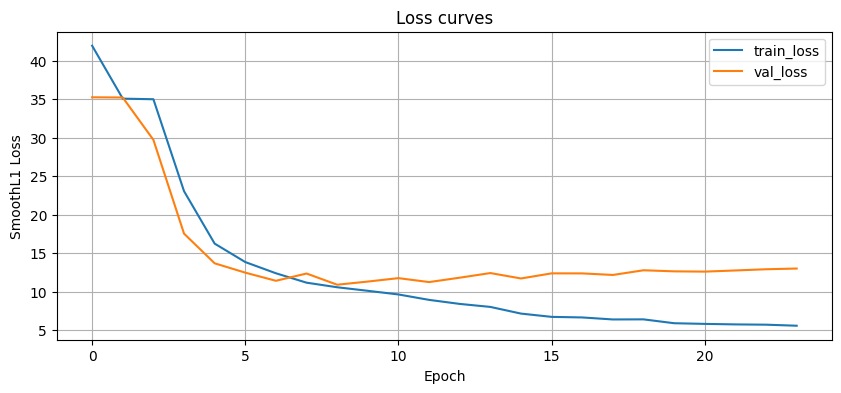

In [15]:

# plots
plt.figure(figsize=(10,4))
plt.plot(train_hist['train_loss'], label='train_loss')
plt.plot(train_hist['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('SmoothL1 Loss')
plt.legend()
plt.grid(True)
plt.title('Loss curves')
plt.show()


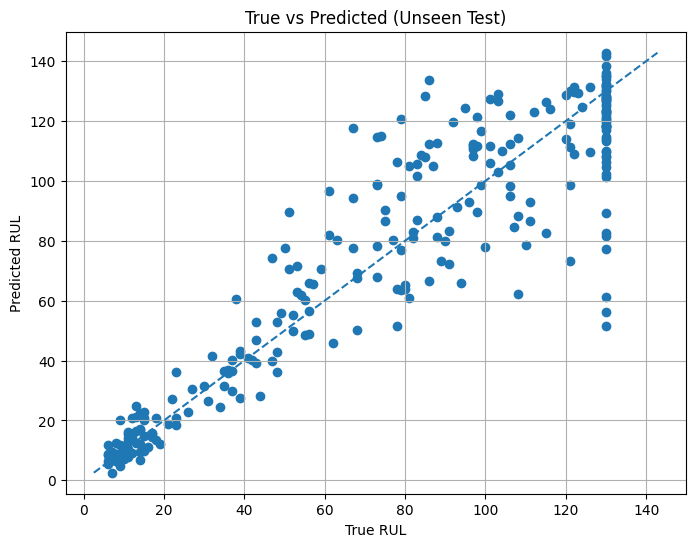

In [16]:

plt.figure(figsize=(8,6))
plt.scatter(y_test, preds)
mn = min(y_test.min(), preds.min())
mx = max(y_test.max(), preds.max())
plt.plot([mn,mx],[mn,mx],'--')
plt.xlabel('True RUL')
plt.ylabel('Predicted RUL')
plt.title('True vs Predicted (Unseen Test)')
plt.grid(True)
plt.show()



In [17]:
## unseen data testing 

In [18]:
with open("scaler_fd002_hyper.pkl", "rb") as f:
    loaded_scaler = pickle.load(f)

In [19]:
import torch
import torch.nn as nn

selected_features = [
    "op_setting_1","op_setting_2","op_setting_3",
    "sensor_2","sensor_3","sensor_4","sensor_7","sensor_8",
    "sensor_9","sensor_11","sensor_12","sensor_13","sensor_14","sensor_15"
]

class SmallModel(nn.Module):
    def __init__(self, input_dim, cnn_filters=64, lstm_hidden=128, lstm_layers=2, dropout=0.3):
        super().__init__()
        self.cnn = nn.Conv1d(input_dim, cnn_filters, kernel_size=3, padding=1)
        self.lstm = nn.LSTM(
            input_size=cnn_filters,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if lstm_layers>1 else 0.0
            )
        self.attn = Attention(2 * lstm_hidden)
        self.fc = nn.Sequential(
            nn.Linear(2 * lstm_hidden, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 1)
            )
    def forward(self, x):
    # x: (B, T, F)
        x = x.permute(0,2,1) # (B, F, T) for Conv1d
        x = self.cnn(x)
        x = x.permute(0,2,1) # (B, T, C)
        x, _ = self.lstm(x)
        x = self.attn(x)
        return self.fc(x) 





In [20]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SmallModel(input_dim=len(selected_features)).to(DEVICE)
model.load_state_dict(torch.load("best_model_fd002_hyper.pth", map_location=device))


print("Loaded model successfully!")

Loaded model successfully!


In [21]:
model.eval()
preds = []
with torch.no_grad():
    for Xb, _ in test_loader:
        Xb = Xb.to(DEVICE)
        out = model(Xb)                 # shape (batch,1)
        preds.extend(out.cpu().numpy().flatten())

preds = np.array(preds).flatten()
# preds correspond to engines in test_units order
# y_test we built earlier is clipped RUL from rul_map; use that for metric
y_true = y_test.copy()

# compute RMSE (per-engine)
rmse = math.sqrt(mean_squared_error(y_true, preds))
print(f"TEST RMSE (per-engine): {rmse:.6f}")

TEST RMSE (per-engine): 17.922228


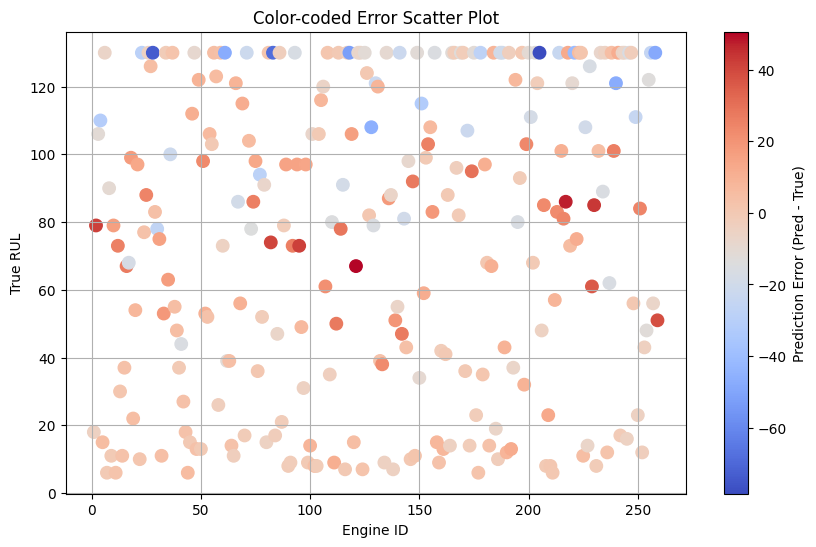

In [22]:
errors = preds - y_true

plt.figure(figsize=(10,6))
plt.scatter(test_units, y_true, c=errors, cmap="coolwarm", s=80)
plt.colorbar(label="Prediction Error (Pred - True)")
plt.xlabel("Engine ID")
plt.ylabel("True RUL")
plt.title("Color-coded Error Scatter Plot")
plt.grid(True)
plt.show()


In [27]:
UNSEEN_PATH = "data/test_FD002.txt"
UNSEEN_TRUE_RUL_PATH = "data/RUL_FD002.txt"

# Load unseen raw
unseen_raw = pd.read_csv(UNSEEN_PATH, sep=" ", header=None).dropna(axis=1, how="all")
unseen_raw = unseen_raw.iloc[:, :len(cols)]
unseen_raw.columns = cols

# keep only selected features
unseen_df = unseen_raw[["unit","cycle"] + selected_features].copy()

# Load true RUL values (each line corresponds to each engine in order)
unseen_true_ruls = np.loadtxt(UNSEEN_TRUE_RUL_PATH)
unseen_units = sorted(unseen_df["unit"].unique())

# Map engine → true rul
unseen_rul_map = {u: r for u, r in zip(unseen_units, unseen_true_ruls)}

# Scale features
unseen_df[selected_features] = loaded_scaler.transform(unseen_df[selected_features])


c:\Python312\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [28]:
def build_unseen_last_windows(df, rul_map, seq_len=80):
    Xu, yu, units_order = [], [], sorted(df["unit"].unique())

    for uid in units_order:
        unit_df = df[df["unit"] == uid].reset_index(drop=True)
        feats = unit_df[selected_features].values

        # pad or slice
        if len(unit_df) < seq_len:
            pad_len = seq_len - len(unit_df)
            pad = np.repeat(feats[[0]], pad_len, axis=0)
            window = np.vstack([pad, feats])
        else:
            window = feats[-seq_len:]

        Xu.append(window.astype(np.float32))
        yu.append(rul_map[uid])  # true RUL from unseen file

    return np.array(Xu, dtype=np.float32), np.array(yu, dtype=np.float32), units_order


X_unseen, y_unseen, unseen_units = build_unseen_last_windows(
    unseen_df, unseen_rul_map, SEQ_LEN
)

unseen_loader = DataLoader(
    SeqDataset(X_unseen, y_unseen), batch_size=64, shuffle=False
)

print("Unseen set:", X_unseen.shape, y_unseen.shape)


Unseen set: (259, 80, 14) (259,)


In [29]:
model.eval()
unseen_preds = []

with torch.no_grad():
    for Xb, _ in unseen_loader:
        Xb = Xb.to(DEVICE)
        out = model(Xb)
        unseen_preds.extend(out.cpu().numpy().flatten())

unseen_preds = np.array(unseen_preds)


In [ ]:
model.eval()
unseen_preds = []

with torch.no_grad():
    for Xb in unseen_loader:
        Xb = Xb.to(DEVICE)
        out = model(Xb).cpu().numpy().flatten()
        unseen_preds.extend(out)

unseen_preds = np.array(unseen_preds)
print("Predictions for unseen:", unseen_preds.shape)


Predictions for unseen: (248,)


In [30]:
rmse_unseen = math.sqrt(mean_squared_error(y_unseen, unseen_preds))
mae_unseen = mean_absolute_error(y_unseen, unseen_preds)

print(f"Unseen RMSE: {rmse_unseen:.4f},  MAE: {mae_unseen:.4f}")


Unseen RMSE: 26.7638,  MAE: 18.1854


In [31]:
print("\nEngine | True RUL | Predicted RUL")
for u, t, p in zip(unseen_units, y_unseen, unseen_preds):
    print(f"{u:3d}     {t:7.2f}     {p:7.2f}")



Engine | True RUL | Predicted RUL
  1       18.00       13.45
  2       79.00      120.64
  3      106.00       95.03
  4      110.00       78.55
  5       15.00       20.66
  6      155.00      123.19
  7        6.00        5.62
  8       90.00       79.96
  9       11.00       10.63
 10       79.00       95.02
 11        6.00        8.67
 12       73.00       98.47
 13       30.00       31.34
 14       11.00       14.08
 15       37.00       40.23
 16       67.00       94.37
 17       68.00       50.32
 18       99.00      116.56
 19       22.00       27.06
 20       54.00       61.82
 21       97.00      110.70
 22       10.00       11.30
 23      142.00      101.19
 24       77.00       80.14
 25       88.00      112.79
 26      163.00      125.63
 27      126.00      131.20
 28      138.00       56.19
 29       83.00       87.00
 30       78.00       51.60
 31       75.00       90.35
 32       11.00       15.42
 33       53.00       71.70
 34      173.00      128.45
 35       63.

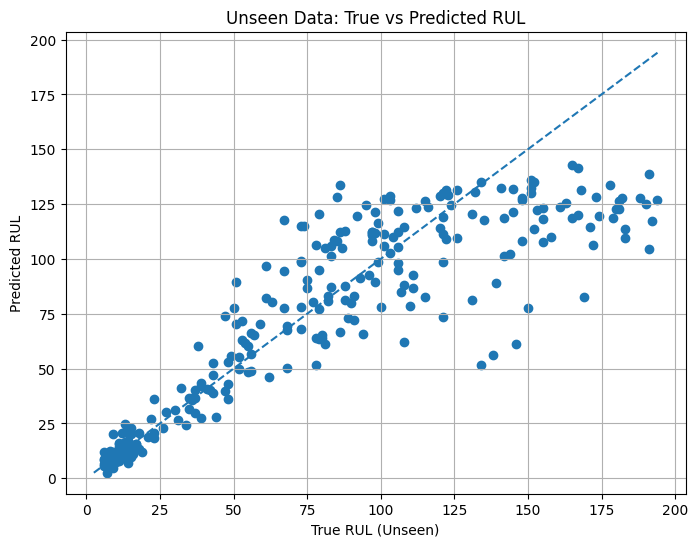

In [32]:
plt.figure(figsize=(8,6))
plt.scatter(y_unseen, unseen_preds)
mn = min(y_unseen.min(), unseen_preds.min())
mx = max(y_unseen.max(), unseen_preds.max())
plt.plot([mn, mx], [mn, mx], '--')
plt.xlabel("True RUL (Unseen)")
plt.ylabel("Predicted RUL")
plt.title("Unseen Data: True vs Predicted RUL")
plt.grid(True)
plt.show()


In [37]:
# Load true RUL values for unseen data
true_rul_df = pd.read_csv(UNSEEN_TRUE_RUL_PATH, header=None, names=["RUL"])

# Verify length match
print("Predictions:", len(preds), " True RUL:", len(true_rul_df))

# Print comparison
print("\nPredicted vs Actual RUL for unseen engines:")
for uid, pred, actual in zip(unseen_units, preds, true_rul_df["RUL"]):
    print(f"Engine {uid:3d} Predicted: {pred:.2f} | Actual: {actual:.2f}")


Predictions: 259  True RUL: 259

Predicted vs Actual RUL for unseen engines:
Engine   1 Predicted: 13.45 | Actual: 18.00
Engine   2 Predicted: 120.64 | Actual: 79.00
Engine   3 Predicted: 95.03 | Actual: 106.00
Engine   4 Predicted: 78.55 | Actual: 110.00
Engine   5 Predicted: 20.66 | Actual: 15.00
Engine   6 Predicted: 123.19 | Actual: 155.00
Engine   7 Predicted: 5.62 | Actual: 6.00
Engine   8 Predicted: 79.96 | Actual: 90.00
Engine   9 Predicted: 10.63 | Actual: 11.00
Engine  10 Predicted: 95.02 | Actual: 79.00
Engine  11 Predicted: 8.67 | Actual: 6.00
Engine  12 Predicted: 98.47 | Actual: 73.00
Engine  13 Predicted: 31.34 | Actual: 30.00
Engine  14 Predicted: 14.08 | Actual: 11.00
Engine  15 Predicted: 40.23 | Actual: 37.00
Engine  16 Predicted: 94.37 | Actual: 67.00
Engine  17 Predicted: 50.32 | Actual: 68.00
Engine  18 Predicted: 116.56 | Actual: 99.00
Engine  19 Predicted: 27.06 | Actual: 22.00
Engine  20 Predicted: 61.82 | Actual: 54.00
Engine  21 Predicted: 110.70 | Actual: 97

In [34]:
comparison_df = pd.DataFrame({
    "EngineID": unseen_units,
    "Predicted_RUL": preds,
    "Actual_RUL": true_rul_df["RUL"]
})

print("\nComparison Table:")
print(comparison_df.head())



Comparison Table:
   EngineID  Predicted_RUL  Actual_RUL
0         1      13.452175          18
1         2     120.636948          79
2         3      95.027580         106
3         4      78.552925         110
4         5      20.662212          15


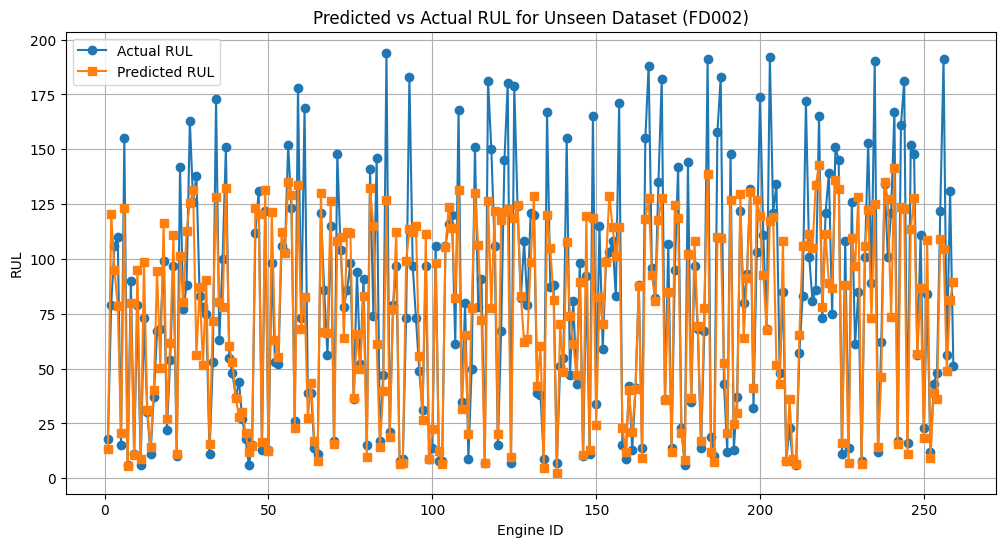

In [35]:
plt.figure(figsize=(12,6))
plt.plot(comparison_df["EngineID"], comparison_df["Actual_RUL"], marker="o", label="Actual RUL")
plt.plot(comparison_df["EngineID"], comparison_df["Predicted_RUL"], marker="s", label="Predicted RUL")

plt.xlabel("Engine ID")
plt.ylabel("RUL")
plt.title("Predicted vs Actual RUL for Unseen Dataset (FD002)")
plt.legend()
plt.grid(True)
plt.show()


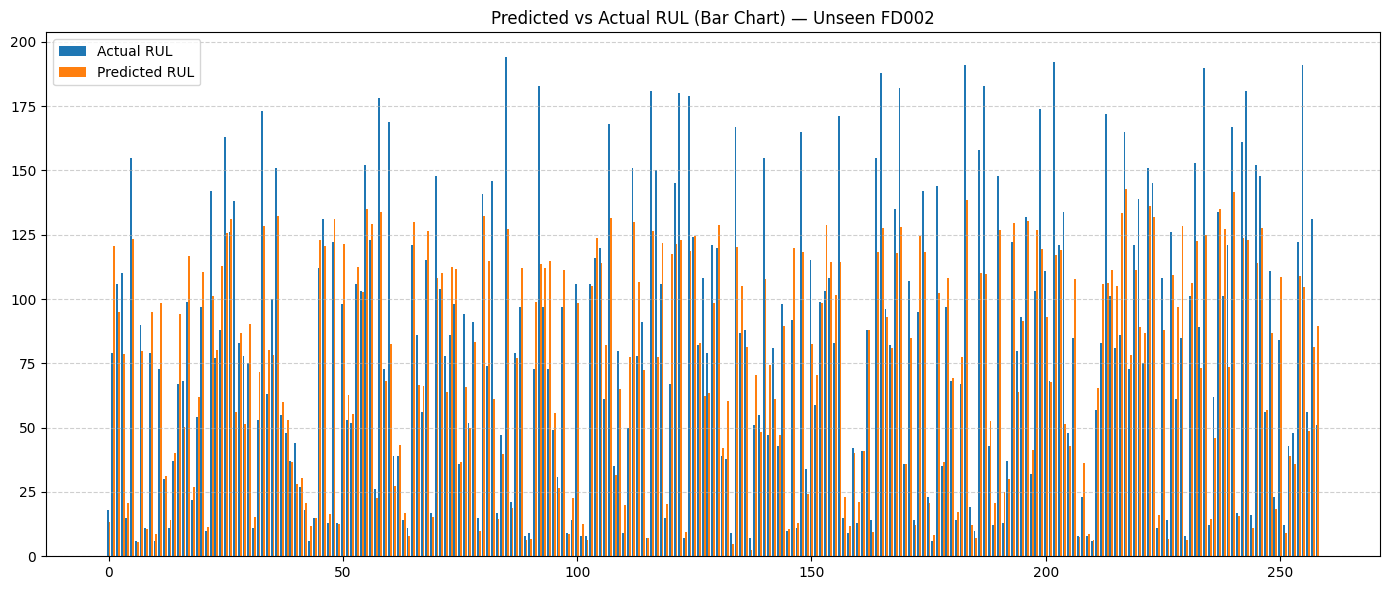

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Width of each bar
bar_width = 0.4

# X locations for engines
x = np.arange(len(comparison_df))

plt.figure(figsize=(14,6))

# Actual RUL bars
plt.bar(x - bar_width/2, comparison_df["Actual_RUL"], 
        width=bar_width, label="Actual RUL")

# Predicted RUL bars
plt.bar(x + bar_width/2, comparison_df["Predicted_RUL"], 
        width=bar_width, label="Predicted RUL")



plt.title("Predicted vs Actual RUL (Bar Chart) — Unseen FD002")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()
